In [40]:
import pandas as pd
df = pd.read_csv('./data/stocks.csv')
df.tail(5)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
602957,2023-11-29 00:00:00-05:00,26.360001,26.397499,26.120001,26.150000,1729147,0.0,0.0,PPL
602958,2023-11-29 00:00:00-05:00,27.680000,28.535000,27.680000,28.350000,1940066,0.0,0.0,FITB
602959,2023-11-29 00:00:00-05:00,75.940002,76.555000,75.257500,75.610001,298699,0.0,0.0,IFF
602960,2023-11-29 00:00:00-05:00,45.230000,45.259998,44.040001,44.209999,2217579,0.0,0.0,CCJ
602961,2023-11-29 00:00:00-05:00,84.629997,84.995003,83.529999,83.889999,830092,0.0,0.0,LYV


In [14]:
# Filter the dataset for rows where Company is 'NVDA'
df = df[df['Company'] == 'NVDA']

# Display the last 4 rows of the filtered dataset
df.tail(4)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
601002,2023-11-24 00:00:00-05:00,484.700012,489.209991,477.450012,477.760010,29464500,0.0,0.0,NVDA
601493,2023-11-27 00:00:00-05:00,478.000000,485.299988,476.519989,482.420013,39566200,0.0,0.0,NVDA
601984,2023-11-28 00:00:00-05:00,482.359985,483.230011,474.730011,478.209991,40089000,0.0,0.0,NVDA
602475,2023-11-29 00:00:00-05:00,483.790009,487.619904,478.635406,480.734985,20498046,0.0,0.0,NVDA


In [15]:
df = df[['Date','Close']]
df.tail(4)

,Date,Close
601002,2023-11-24 00:00:00-05:00,477.760010
601493,2023-11-27 00:00:00-05:00,482.420013
601984,2023-11-28 00:00:00-05:00,478.209991
602475,2023-11-29 00:00:00-05:00,480.734985


In [16]:
import datetime

def str_to_datetime(s):
    """
    Converts a string in the format 'YYYY-MM-DD HH:MM:SS-TZ' to a date object (YYYY-MM-DD).
    
    Args:
    - s (str): The input string containing the timestamp.
    
    Returns:
    - datetime.date: A date object with year, month, and day.
    """
    # Extract the date part (before the space)
    date_part = s.split(' ')[0]
    year, month, day = map(int, date_part.split('-'))
    return datetime.date(year, month, day)

In [17]:
# Apply the function to the 'Date' column
df['Date'] = df['Date'].apply(str_to_datetime)

In [18]:
df.index = df.pop('Date')

In [19]:
df

,Close
Date,
2018-11-29,39.037853
2018-11-30,40.543697
2018-12-03,42.183514
2018-12-04,38.975834
2018-12-06,39.268578
...,...
2023-11-22,487.160004
2023-11-24,477.760010
2023-11-27,482.420013


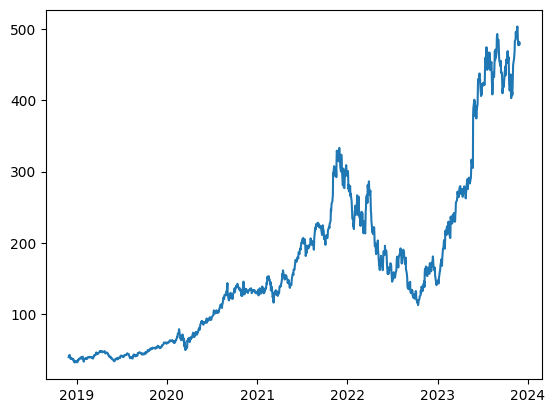

In [20]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

# In time series forecasting, windowing means taking a fixed number of past values (n) as input (X) and using the next value as the target (Y).


In [21]:

import numpy as np
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)  # Convert to datetime
    last_date = pd.to_datetime(last_date_str)

    # Ensure the DataFrame has a DateTimeIndex
    if not isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.index = pd.to_datetime(dataframe.index)

    target_date = first_date
    dates = []
    X, Y = [], []
    last_time = False

    while True:
        # Get the last (n+1) rows up to the target date
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            # Skip if not enough data
            print(f"Skipping target date {target_date}: insufficient data")
            if last_time:
                break
            next_target_date = target_date + datetime.timedelta(days=1)
            if next_target_date > last_date:
                break
            target_date = next_target_date
            continue

        # Extract features (X) and target (Y)
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next target date (7 days later)
        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if len(next_week) < 2:
            break  # No more data to process

        next_target_date = next_week.index[1]  # Get the next valid date
        if last_time:
            break

        target_date = next_target_date

        if target_date >= last_date:
            last_time = True

    # Create a new DataFrame for the results
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    # Add feature columns
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n - i}'] = X[:, i]

    # Add target column
    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df, '2022-11-29', '2023-11-29', n=3)
print(windowed_df)

    Target Date    Target-3    Target-2    Target-1      Target
0    2022-11-29  165.089020  162.600540  158.173264  156.294418
1    2022-11-30  162.600540  158.173264  156.294418  169.169830
2    2022-12-01  158.173264  156.294418  169.169830  171.289062
3    2022-12-02  156.294418  169.169830  171.289062  168.699982
4    2022-12-05  169.169830  171.289062  168.699982  166.040939
..          ...         ...         ...         ...         ...
247  2023-11-22  492.980011  504.089996  499.440002  487.160004
248  2023-11-24  504.089996  499.440002  487.160004  477.760010
249  2023-11-27  499.440002  487.160004  477.760010  482.420013
250  2023-11-28  487.160004  477.760010  482.420013  478.209991
251  2023-11-29  477.760010  482.420013  478.209991  480.734985

[252 rows x 5 columns]


In [22]:
def windowed_df_to_date_X_y(windowed_dataframe):
    # Convert the dataframe to a NumPy array for easier slicing
    df_as_np = windowed_dataframe.to_numpy()

    # Extract the first column (dates) to keep track of time
    dates = df_as_np[:, 0]

    # Extract all columns except the first (dates) and last (target price)
    middle_matrix = df_as_np[:, 1:-1]

    # Reshape X to match LSTM input format: (samples, time steps, features)
    # Here, 'time steps' = window size (n) and 'features' = 1 (stock price)
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    # Extract the last column (Target price for prediction)
    Y = df_as_np[:, -1]

    # Convert X and Y to float32 for TensorFlow compatibility
    return dates, X.astype(np.float32), Y.astype(np.float32)

# Convert the windowed DataFrame into LSTM-compatible input and labels
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Print the shape of extracted data
# - dates.shape -> (num_samples,)
# - X.shape -> (num_samples, window_size, 1) -> LSTM input format
# - y.shape -> (num_samples,) -> Target values
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

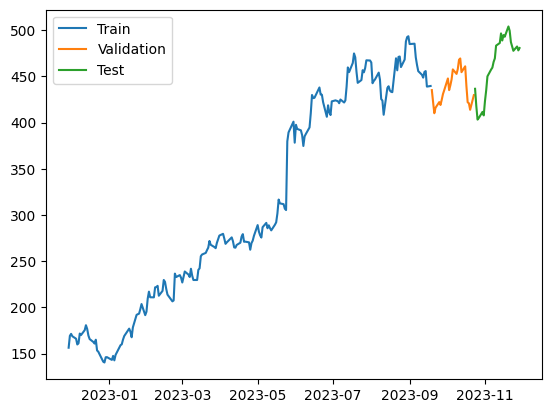

In [23]:
#Splitting the data into training, validation, and test sets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
# Adam (Adaptive Moment Estimation) is an optimizer that adjusts the learning rate dynamically.
# It combines the best of two other optimizers:
# 	•	Momentum → Remembers past gradients to speed up learning.
# 	•	RMSProp → Adjusts the learning rate individually for each parameter.
# The learning rate is set to 0.001.

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 108370.8438 - mean_absolute_error: 310.1125 - val_loss: 190477.0625 - val_mean_absolute_error: 436.0966
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 104475.1328 - mean_absolute_error: 303.5682 - val_loss: 189888.4844 - val_mean_absolute_error: 435.4212
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 107343.6719 - mean_absolute_error: 307.9178 - val_loss: 189168.6250 - val_mean_absolute_error: 434.5938
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109742.0391 - mean_absolute_error: 311.5589 - val_loss: 188293.5156 - val_mean_absolute_error: 433.5858
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 102660.4219 - mean_absolute_error: 300.0864 - val_loss: 187041.4844 - val_mean_absolute_error: 432.1391
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 102805.0312 - mean_absolute_error: 299.5826 - val_loss: 184646.4844 - val_mean_absolute_error: 429.3595
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


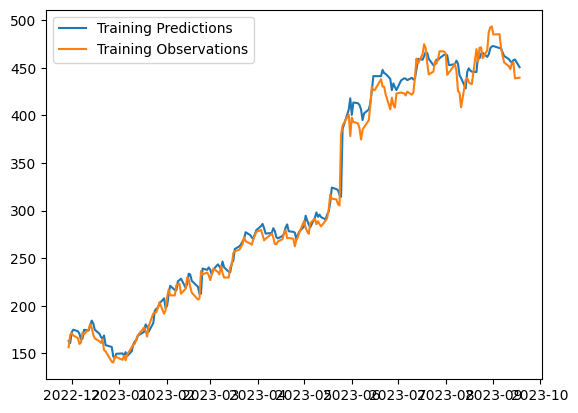

In [25]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


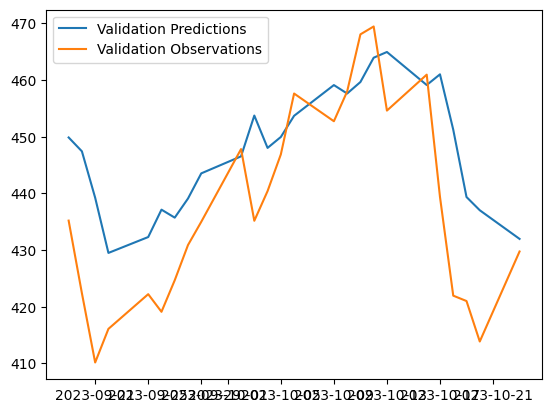

In [26]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


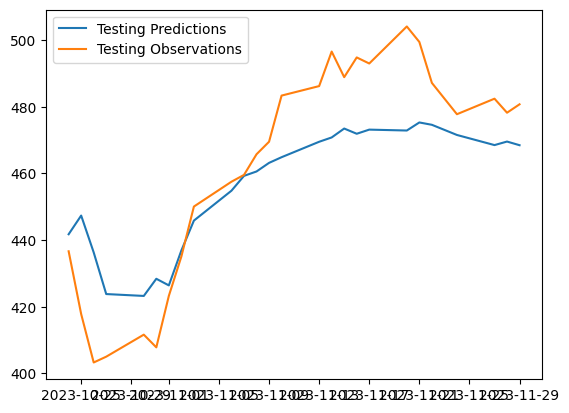

In [27]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

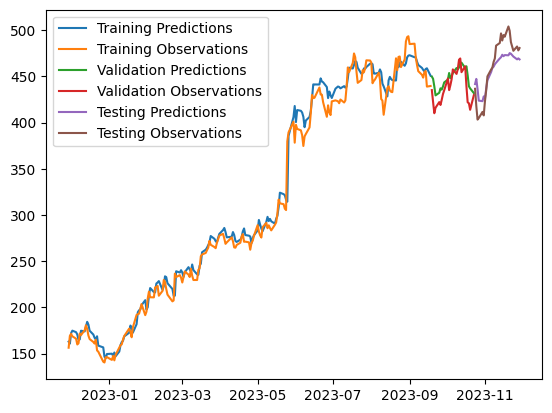

In [28]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [29]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

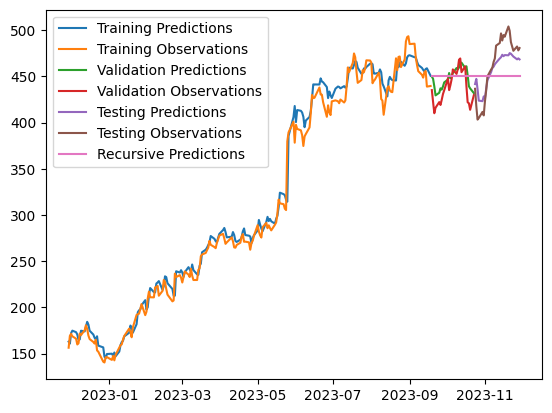

In [30]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [31]:
#Predicting the next day's stock price
last_3_days = df['Close'].iloc[-3:].to_numpy().reshape(1, 3, 1)
next_day_price = model.predict(last_3_days).flatten()[0]
print(f"Predicted next day's stock price: {next_day_price}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted next day's stock price: 469.0748291015625


In [32]:
# Step 1: Predict the next 5 days' stock prices

future_prices = []
last_3_days = df['Close'].iloc[-3:].to_numpy().reshape(1, 3, 1)

# Predict the next 5 days (next week) stock prices
for _ in range(5):
    next_day_price = model.predict(last_3_days).flatten()[0]
    future_prices.append(next_day_price)
    
    # Update last_3_days by adding new prediction and removing the oldest value
    last_3_days = np.append(last_3_days[:, 1:, :], [[[next_day_price]]], axis=1)

# Print predicted stock prices for the next week
print("Predicted next week's stock prices:", future_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted next week's stock prices: [np.float32(469.07483), np.float32(465.37372), np.float32(463.50974), np.float32(462.60526), np.float32(462.15265)]


In [33]:
# Step 2: Create dates for the next week

# Get the last date in the dataset
last_date = df.index[-1]

# Create dates for the next week
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=5, freq='D')

# Print future dates
print("Future dates for the next week:", future_dates)

Future dates for the next week: DatetimeIndex(['2023-11-30', '2023-12-01', '2023-12-02', '2023-12-03',
               '2023-12-04'],
              dtype='datetime64[ns]', freq='D')


In [34]:
future_prices
# future_dates

[np.float32(469.07483),
 np.float32(465.37372),
 np.float32(463.50974),
 np.float32(462.60526),
 np.float32(462.15265)]

In [35]:
#create a new DataFrame with the predicted stock prices and dates
future_df = pd.DataFrame({'Date': future_dates, 'Close': future_prices})
future_df

,Date,Close
0,2023-11-30,469.074829
1,2023-12-01,465.373718
2,2023-12-02,463.509735
3,2023-12-03,462.605255
4,2023-12-04,462.152649


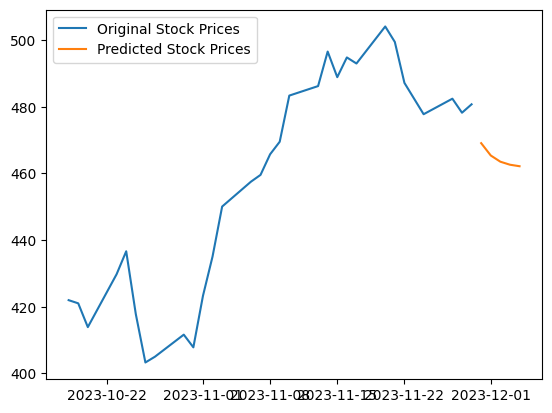

In [36]:
# Plot both the original (last 30 days) and predicted stock prices (next 5 days)
plt.plot(df.index[-30:], df['Close'].iloc[-30:], label='Original Stock Prices')
plt.plot(future_dates, future_prices, label='Predicted Stock Prices')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [37]:
import sys
sys.executable

'/Users/ankitpokhrel/Desktop/stock_price_prediction/myenv/bin/python'